Problem:
In this project, we delve into a dataset encapsulating various health metrics from heart patients, including age, blood pressure, heart rate, and more. Our goal is to develop a predictive model capable of accurately identifying individuals with heart disease. Given the grave implications of missing a positive diagnosis, our primary emphasis is on ensuring that the model identifies all potential patients, making recall for the positive class a crucial metric.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Read dataset
df = pd.read_csv(r"C:\Users\lenovo\Downloads\archive (6)\heart.csv")
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Dataset Description:

age	Age of the patient in years,
sex	Gender of the patient (0 = male, 1 = female),
cp	Chest pain type:
0: Typical angina
1: Atypical angina
2: Non-anginal pain
3: Asymptomatic,
trestbps	Resting blood pressure in mm Hg,
chol	Serum cholesterol in mg/dl,
fbs	Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false),
restecg	Resting electrocardiographic results:
0: Normal
1: Having ST-T wave abnormality,
2: Showing probable or definite left ventricular hypertrophy,
thalach	Maximum heart rate achieved during a stress test,
exang	Exercise-induced angina (1 = yes, 0 = no),
oldpeak	ST depression induced by exercise relative to rest,
slope	Slope of the peak exercise ST segment:
0: Upsloping
1: Flat
2: Downsloping,
ca	Number of major vessels (0-4) colored by fluoroscopy,
thal	Thalium stress test result:
0: Normal
1: Fixed defect
2: Reversible defect
3: Not described,
target	Heart disease status (0 = no disease, 1 = presence of disease)

In [3]:
# Displaying summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Inferences:
Number of Entries: The dataset consists of 303 entries, ranging from index 0 to 302.
Columns: There are 14 columns in the dataset corresponding to various attributes of the patients and results of tests.
Data Types:
Most of the columns (13 out of 14) are of the int64 data type.
Only the oldpeak column is of the float64 data type.
Missing Values: There don't appear to be any missing values in the dataset as each column has 303 non-null entries.

Based on the data types and the feature explanations we had earlier, we can see that 9 columns (sex, cp, fbs, restecg, exang, slope, ca, thal, and target) are indeed numerical in terms of data type, but categorical in terms of their semantics. These features should be converted to string (object) data type for proper analysis and interpretation:

In [4]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [5]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


Numerical Features:
age: The average age of the patients is approximately 54.4 years, with the youngest being 29 and the oldest 77 years.
trestbps: The average resting blood pressure is about 131.62 mm Hg, ranging from 94 to 200 mm Hg.
chol: The average cholesterol level is approximately 246.26 mg/dl, with a minimum of 126 and a maximum of 564 mg/dl.
thalach: The average maximum heart rate achieved is around 149.65, with a range from 71 to 202.
oldpeak: The average ST depression induced by exercise relative to rest is about 1.04, with values ranging from 0 to 6.2.

In [7]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


Categorical Features (object data type):
sex: There are two unique values, with males (denoted as 0) being the most frequent category, occurring 207 times out of 303 entries.
cp: Four unique types of chest pain are present. The most common type is "0", occurring 143 times.
fbs: There are two categories, and the most frequent one is "0" (indicating fasting blood sugar less than 120 mg/dl), which appears 258 times.
restecg: Three unique results are present. The most common result is "1", appearing 152 times.
exang: There are two unique values. The most frequent value is "0" (indicating no exercise-induced angina), which is observed 204 times.
slope: Three unique slopes are present. The most frequent slope type is "2", which occurs 142 times.
ca: There are five unique values for the number of major vessels colored by fluoroscopy, with "0" being the most frequent, occurring 175 times.
thal: Four unique results are available. The most common type is "2" (indicating a reversible defect), observed 166 times.
target: Two unique values indicate the presence or absence of heart disease. The value "1" (indicating the presence of heart disease) is the most frequent, observed in 165 entries.

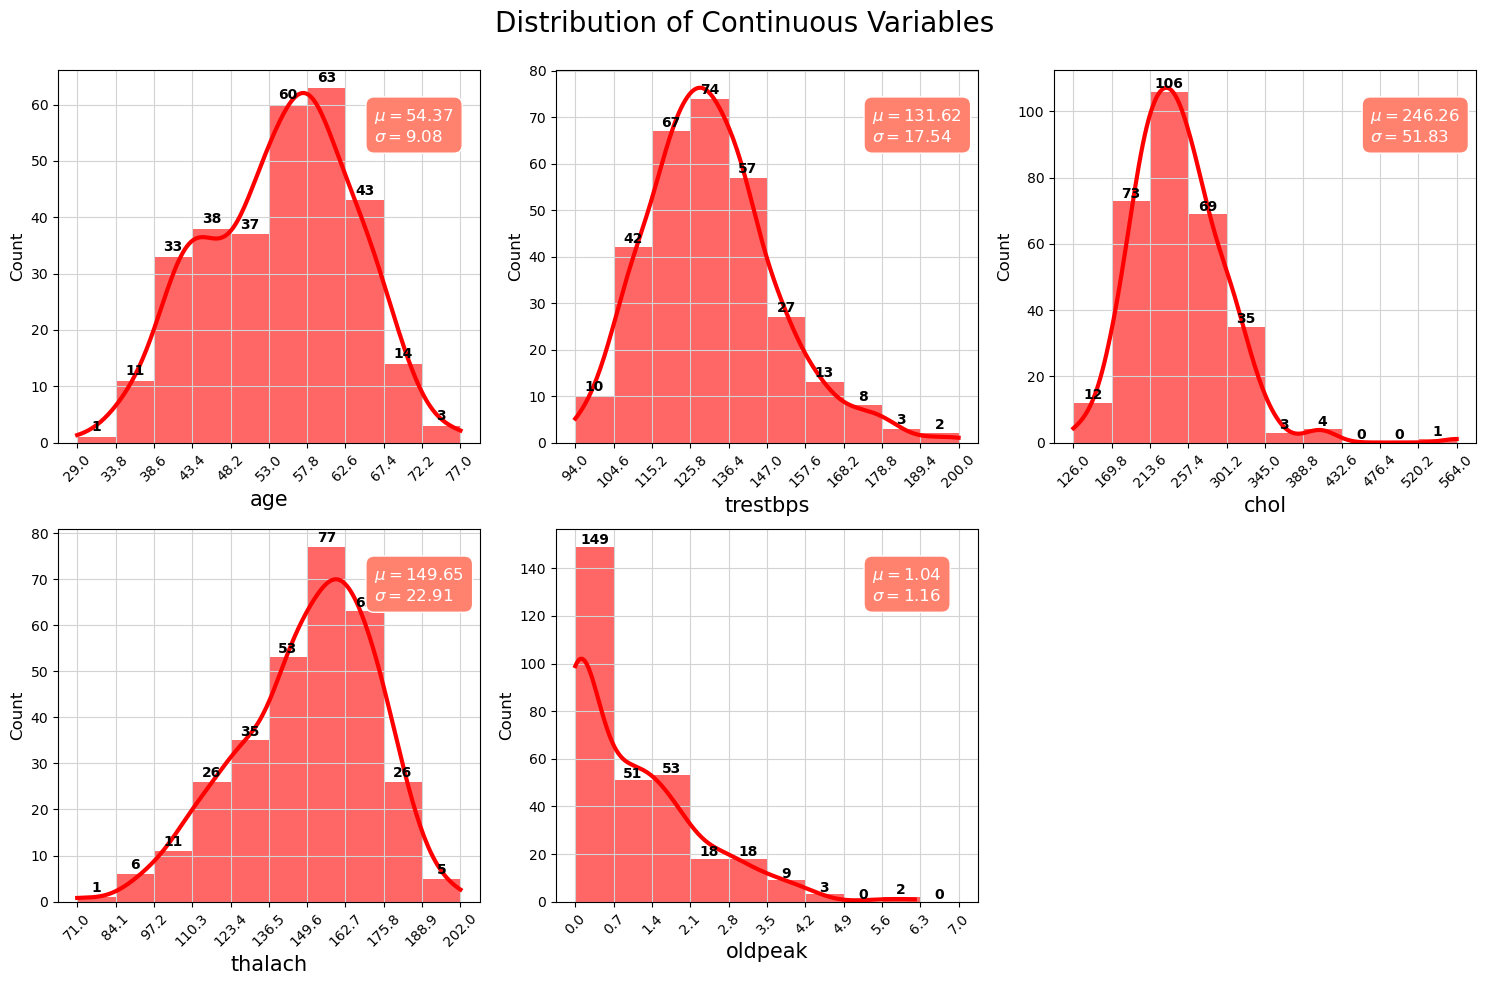

In [8]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='red', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Inferences:
Age (age): The distribution is somewhat uniform, but there's a peak around the late 50s. The mean age is approximately 54.37 years with a standard deviation of 9.08 years.
Resting Blood Pressure (trestbps): The resting blood pressure for most individuals is concentrated around 120-140 mm Hg, with a mean of approximately 131.62 mm Hg and a standard deviation of 17.54 mm Hg.
Serum Cholesterol (chol): Most individuals have cholesterol levels between 200 and 300 mg/dl. The mean cholesterol level is around 246.26 mg/dl with a standard deviation of 51.83 mg/dl.
Maximum Heart Rate Achieved (thalach): The majority of the individuals achieve a heart rate between 140 and 170 bpm during a stress test. The mean heart rate achieved is approximately 149.65 bpm with a standard deviation of 22.91 bpm.
ST Depression Induced by Exercise (oldpeak): Most of the values are concentrated towards 0, indicating that many individuals did not experience significant ST depression during exercise. The mean ST depression value is 1.04 with a standard deviation of 1.16.
Upon reviewing the histograms of the continuous features and cross-referencing them with the provided feature descriptions, everything appears consistent and within expected ranges. There doesn't seem to be any noticeable noise or implausible values among the continuous variables.

In [9]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

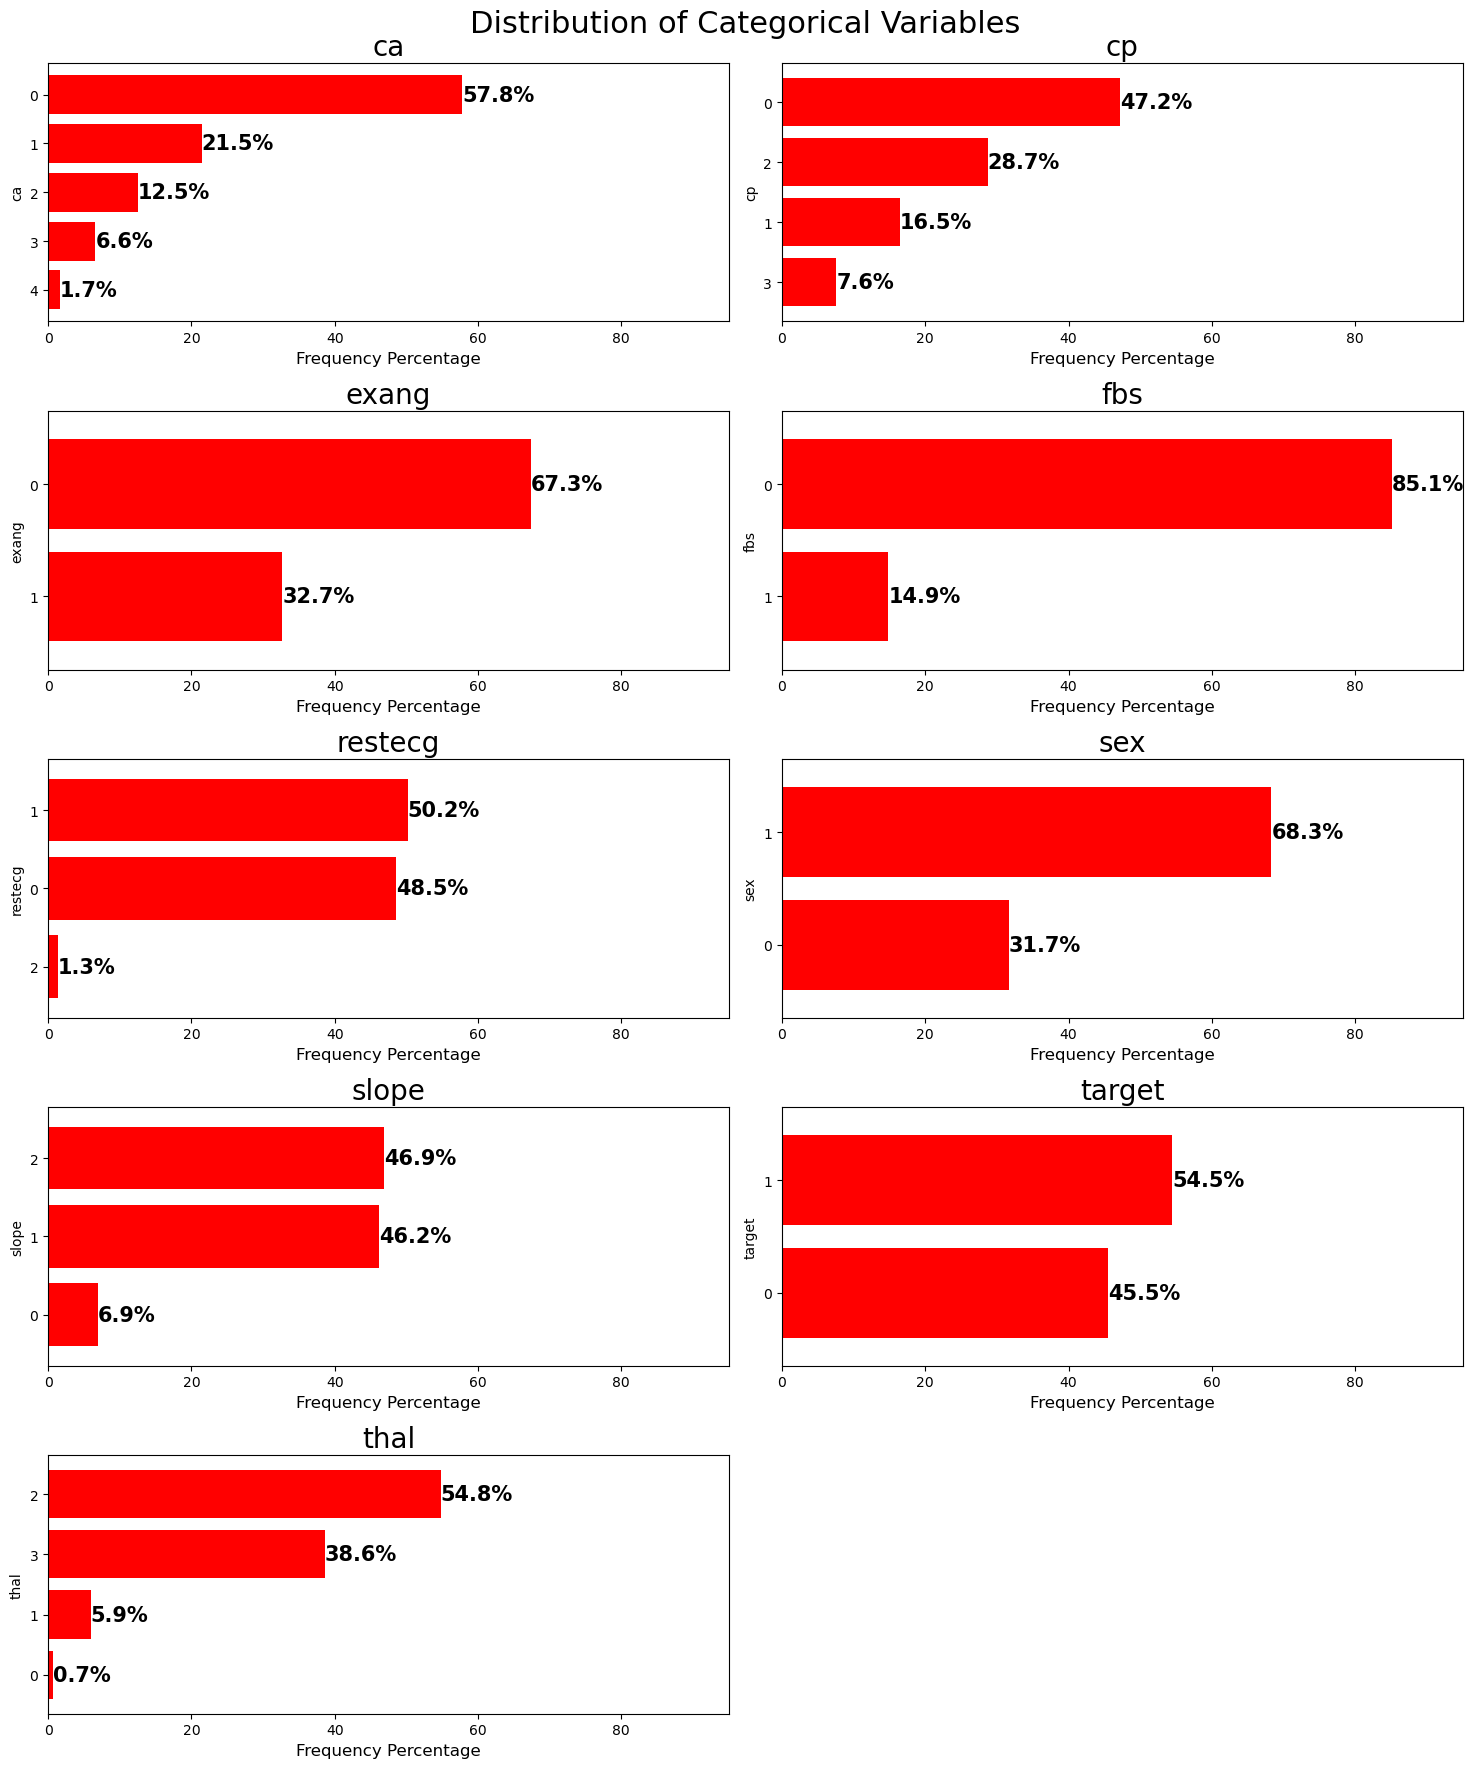

In [10]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Inferences:
Gender (sex): The dataset is predominantly female, constituting a significant majority.
Type of Chest Pain (cp): The dataset shows varied chest pain types among patients. Type 0 (Typical angina) seems to be the most prevalent, but an exact distribution among the types can be inferred from the bar plots.
Fasting Blood Sugar (fbs): A significant majority of the patients have their fasting blood sugar level below 120 mg/dl, indicating that high blood sugar is not a common condition in this dataset.
Resting Electrocardiographic Results (restecg): The results show varied resting electrocardiographic outcomes, with certain types being more common than others. The exact distribution can be gauged from the plots.
Exercise-Induced Angina (exang): A majority of the patients do not experience exercise-induced angina, suggesting that it might not be a common symptom among the patients in this dataset.
Slope of the Peak Exercise ST Segment (slope): The dataset shows different slopes of the peak exercise ST segment. A specific type might be more common, and its distribution can be inferred from the bar plots.
Number of Major Vessels Colored by Fluoroscopy (ca): Most patients have fewer major vessels colored by fluoroscopy, with '0' being the most frequent.
Thalium Stress Test Result (thal): The dataset displays a variety of thalium stress test results. One particular type seems to be more prevalent, but the exact distribution can be seen in the plots.
Presence of Heart Disease (target): The dataset is nearly balanced in terms of heart disease presence, with about 54.5% having it and 45.5% not having it.

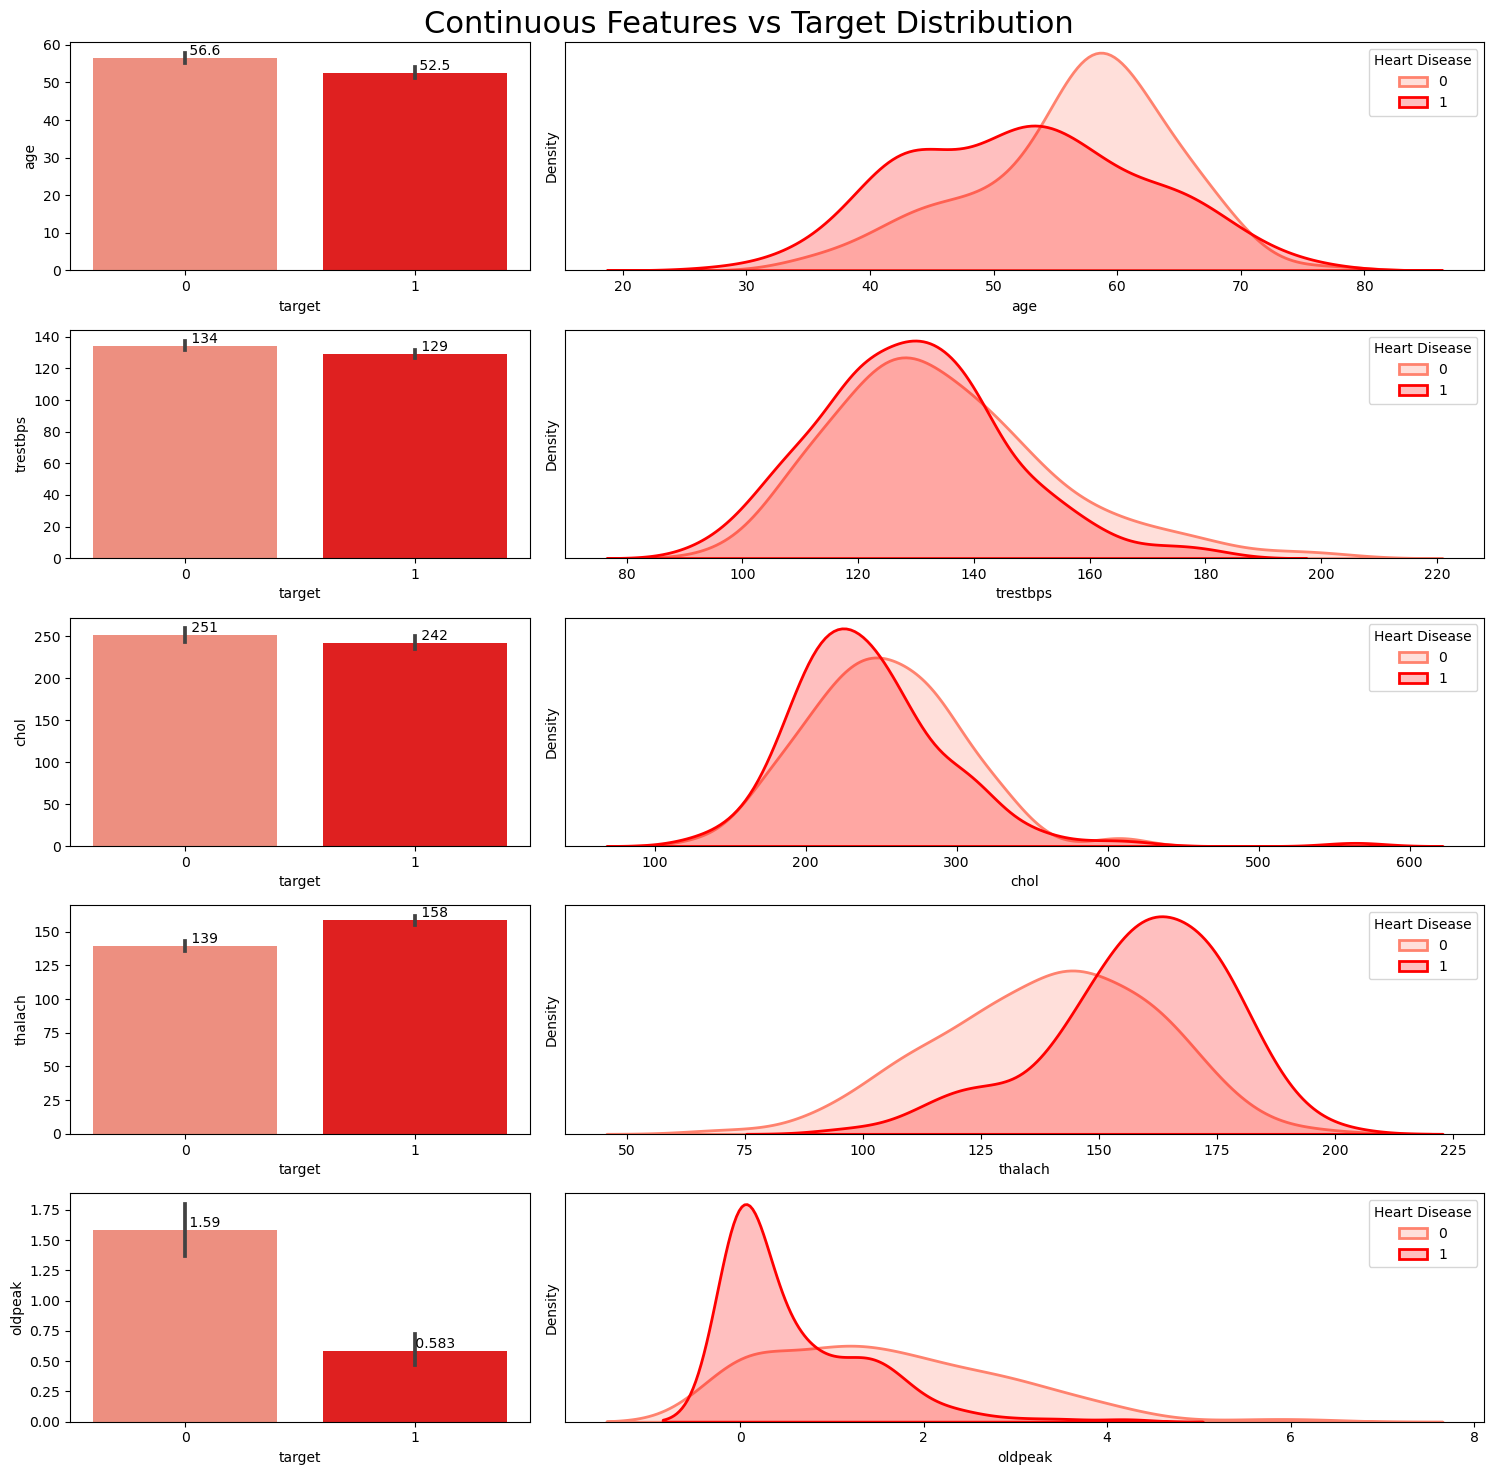

In [11]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

Inferences:
Age (age): The distributions show a slight shift with patients having heart disease being a bit younger on average than those without. The mean age for patients without heart disease is higher.
Resting Blood Pressure (trestbps): Both categories display overlapping distributions in the KDE plot, with nearly identical mean values, indicating limited differentiating power for this feature.
Serum Cholesterol (chol): The distributions of cholesterol levels for both categories are quite close, but the mean cholesterol level for patients with heart disease is slightly lower.
Maximum Heart Rate Achieved (thalach): There's a noticeable difference in distributions. Patients with heart disease tend to achieve a higher maximum heart rate during stress tests compared to those without.
ST Depression (oldpeak): The ST depression induced by exercise relative to rest is notably lower for patients with heart disease. Their distribution peaks near zero, whereas the non-disease category has a wider spread.
Based on the visual difference in distributions and mean values, Maximum Heart Rate (thalach) seems to have the most impact on the heart disease status, followed by ST Depression (oldpeak) and Age (age).

In [12]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

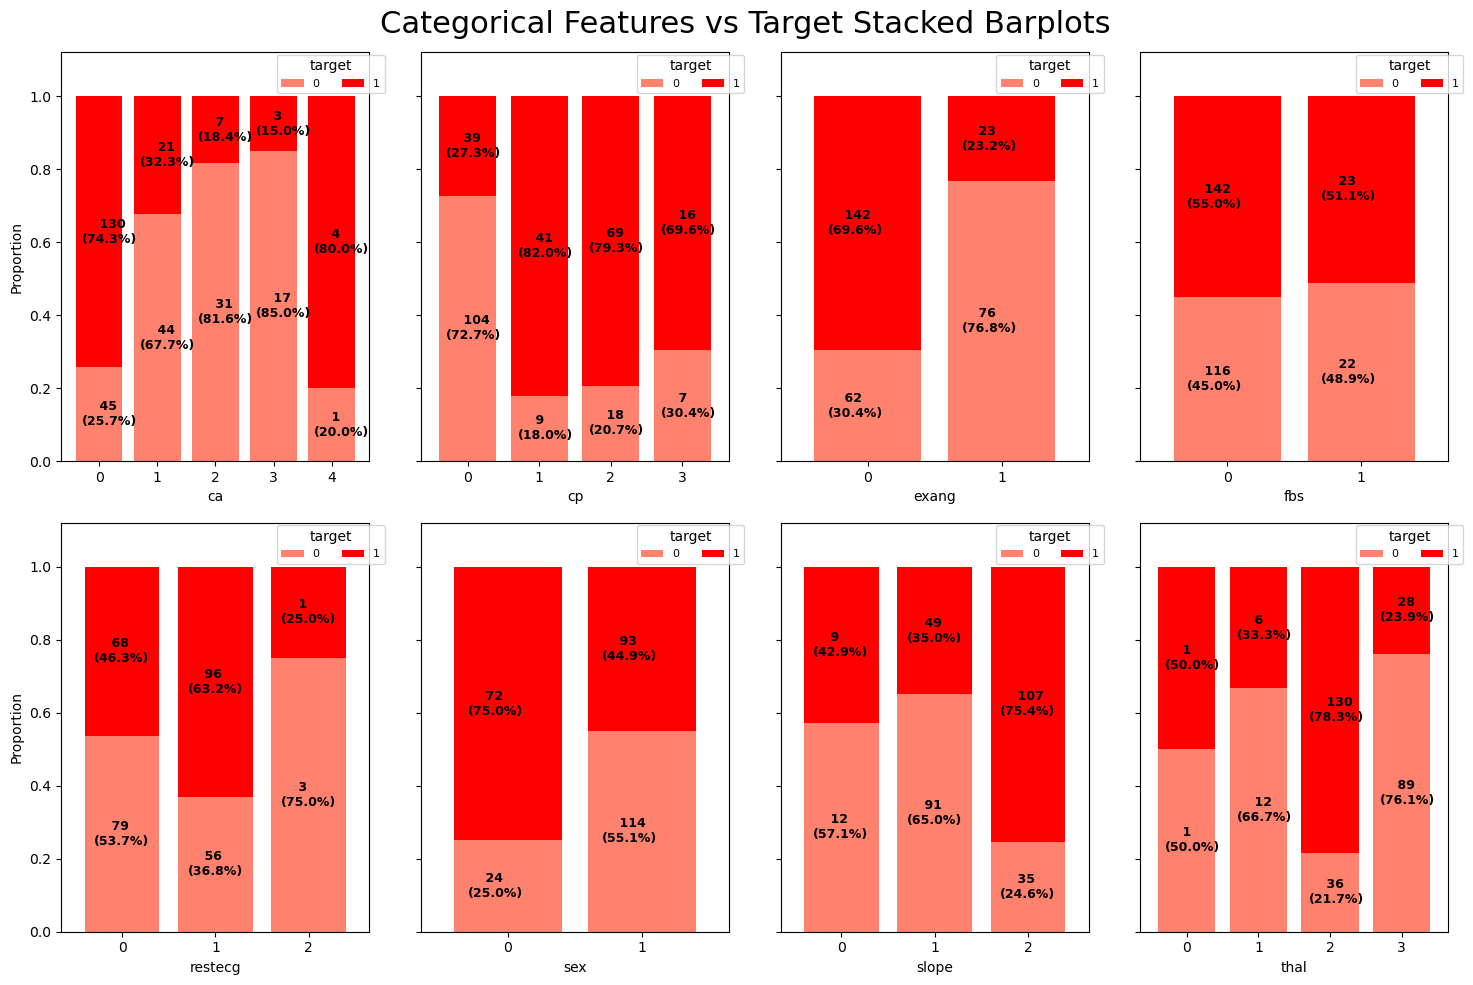

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

Inferences:
Number of Major Vessels (ca): The majority of patients with heart disease have fewer major vessels colored by fluoroscopy. As the number of colored vessels increases, the proportion of patients with heart disease tends to decrease. Especially, patients with 0 vessels colored have a higher proportion of heart disease presence.
Chest Pain Type (cp): Different types of chest pain present varied proportions of heart disease. Notably, types 1, 2, and 3 have a higher proportion of heart disease presence compared to type 0. This suggests the type of chest pain can be influential in predicting the disease.
Exercise Induced Angina (exang): Patients who did not experience exercise-induced angina (0) show a higher proportion of heart disease presence compared to those who did (1). This feature seems to have a significant impact on the target.
Fasting Blood Sugar (fbs): The distribution between those with fasting blood sugar > 120 mg/dl (1) and those without (0) is relatively similar, suggesting fbs might have limited impact on heart disease prediction.
Resting Electrocardiographic Results (restecg): Type 1 displays a higher proportion of heart disease presence, indicating that this feature might have some influence on the outcome.
Sex (sex): Females (1) exhibit a lower proportion of heart disease presence compared to males (0). This indicates gender as an influential factor in predicting heart disease.
Slope of the Peak Exercise ST Segment (slope): The slope type 2 has a notably higher proportion of heart disease presence, indicating its potential as a significant predictor.
Thalium Stress Test Result (thal): The reversible defect category (2) has a higher proportion of heart disease presence compared to the other categories, emphasizing its importance in prediction.
In summary, based on the visual representation:

Higher Impact on Target: ca, cp, exang, sex, slope, and thal
Moderate Impact on Target: restecg
Lower Impact on Target: fbs

# Data Preprocessing

Irrelevant Features Removal
All features in the dataset appear to be relevant based on our EDA. No columns seem redundant or irrelevant. Thus, we'll retain all features, ensuring no valuable information is lost, especially given the dataset's small size.

In [14]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

Upon our above inspection, it is obvious that there are no missing values in our dataset. This is ideal as it means we don't have to make decisions about imputation or removal, which can introduce bias or reduce our already limited dataset size.

In [16]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [17]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

Upon identifying outliers for the specified continuous features, we found the following:

trestbps: 9 outliers
chol: 5 outliers
thalach: 1 outlier
oldpeak: 5 outliers
age: No outliers

One-hot Encoding Decision:
Based on the feature descriptions, let's decide on one-hot encoding:

Nominal Variables: These are variables with no inherent order. They should be one-hot encoded because using them as numbers might introduce an unintended order to the model.

Ordinal Variables: These variables have an inherent order. They don't necessarily need to be one-hot encoded since their order can provide meaningful information to the model.

Given the above explanation:

sex: This is a binary variable with two categories (male and female), so it doesn't need one-hot encoding.
cp: Chest pain type can be considered as nominal because there's no clear ordinal relationship among the different types of chest pain (like Typical angina, Atypical angina, etc.). It should be one-hot encoded.
fbs: This is a binary variable (true or false), so it doesn't need one-hot encoding.
restecg: This variable represents the resting electrocardiographic results. The results, such as "Normal", "Having ST-T wave abnormality", and "Showing probable or definite left ventricular hypertrophy", don't seem to have an ordinal relationship. Therefore, it should be one-hot encoded.
exang: This is a binary variable (yes or no), so it doesn't need one-hot encoding.
slope: This represents the slope of the peak exercise ST segment. Given the descriptions (Upsloping, Flat, Downsloping), it seems to have an ordinal nature, suggesting a particular order. Therefore, it doesn't need to be one-hot encoded.
ca: This represents the number of major vessels colored by fluoroscopy. As it indicates a count, it has an inherent ordinal relationship. Therefore, it doesn't need to be one-hot encoded.
thal: This variable represents the result of a thalium stress test. The different states, like "Normal", "Fixed defect", and "Reversible defect", suggest a nominal nature. Thus, it should be one-hot encoded.
Summary:
Need One-Hot Encoding: cp, restecg, thal
Don't Need One-Hot Encoding: sex, fbs, exang, slope, ca

In [19]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [20]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


Box-Cox transformation is a powerful method to stabilize variance and make the data more normal-distribution-like. It's particularly useful when you're unsure about the exact nature of the distribution you're dealing with, as it can adapt itself to the best power transformation. However, the Box-Cox transformation only works for positive data, so one must be cautious when applying it to features that contain zeros or negative values.

In [21]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [22]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [23]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

The Box-Cox transformation requires all data to be strictly positive. To transform the oldpeak feature using Box-Cox, we can add a small constant (e.g., 0.001) to ensure all values are positive:

In [24]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

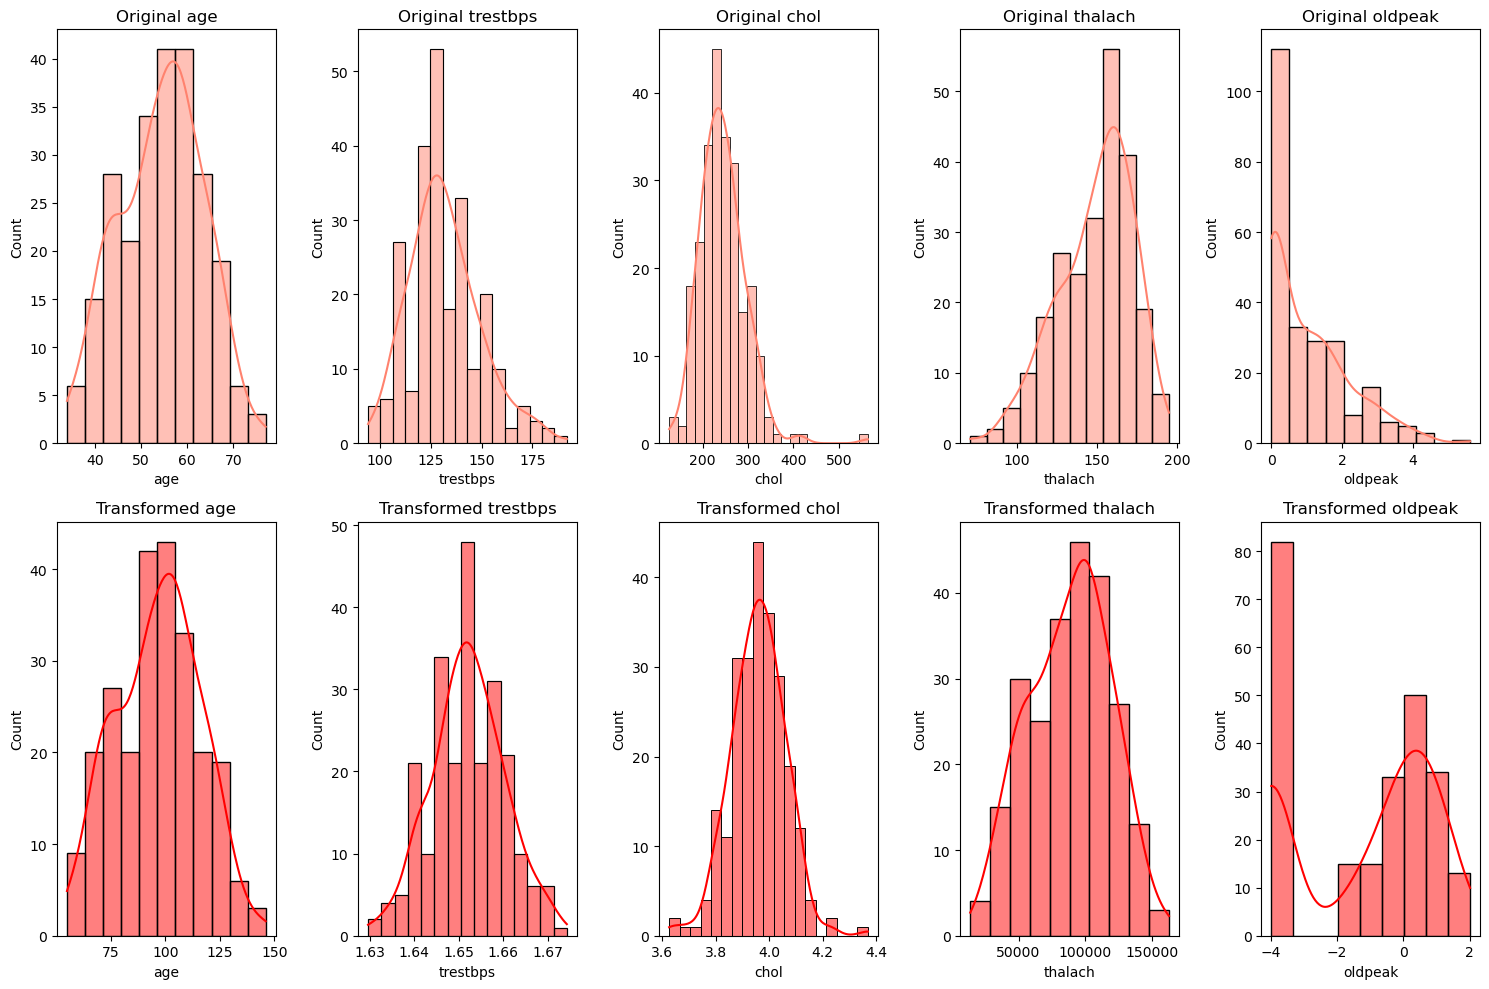

In [25]:
# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15,10))

# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')
    

# Applying Box-Cox Transformation
# Dictionary to store lambda values for each feature
lambdas = {}

for i, col in enumerate(continuous_features):
    # Only apply box-cox for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Applying the same lambda to test data
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

Inference:
1- age: The transformation has made the age distribution more symmetric, bringing it closer to a normal distribution.

2- Trestbps: The distribution of trestbps post-transformation appears to be more normal-like, with reduced skewness.

3- Chol: After applying the Box-Cox transformation, chol exhibits a shape that's more aligned with a normal distribution.

4- Thalach: The thalach feature was already fairly symmetric before the transformation, and post-transformation, it continues to show a similar shape, indicating its original distribution was close to normal.

5- Oldpeak: The transformation improved the oldpeak distribution, but it still doesn't perfectly resemble a normal distribution. This could be due to the inherent nature of the data or the presence of outliers. To enhance its normality, we could consider utilizing advanced transformations such as the Yeo-Johnson transformation, which can handle zero and negative values directly.

Conclusion:
Transforming features to be more normal-like primarily helps in mitigating the impact of outliers, which is particularly beneficial for distance-based algorithms like SVM and KNN. By reducing the influence of outliers, we ensure that these algorithms can compute distances more effectively and produce more reliable results.

In [26]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775303,1,1.652121,4.044510,1,34193.175862,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060224,1,1.651136,3.909224,0,61564.541974,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096543,0,1.646937,3.916242,0,97354.732537,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519131,1,1.641028,3.960430,0,55975.802227,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190680,1,1.656716,4.069854,0,51729.405015,1,1.634849,1,3,False,False,False,True,False,False,False,True


In [27]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

Note: In medical scenarios, especially in the context of diagnosing illnesses, it's often more important to have a high recall (sensitivity) for the positive class (patients with the condition). A high recall ensures that most of the actual positive cases are correctly identified, even if it means some false positives (cases where healthy individuals are misclassified as having the condition). The rationale is that it's generally better to have a few false alarms than to miss out on diagnosing a patient with a potential illness.

 Establishing a function to determine the optimal set of hyperparameters that yield the highest recall for the model. This approach ensures a reusable framework for hyperparameter tuning of subsequent models:

In [28]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [29]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [30]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [31]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [32]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [33]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



Given that the metric values for both the training and test datasets are closely aligned and not significantly different, the model doesn't appear to be overfitting.

Let's create a function that consolidates each model's metrics into a dataframe, facilitating an end-to-end comparison of all models later:

In [35]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [36]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


In [37]:
rf_base = RandomForestClassifier(random_state=0)

Afterward, I am setting up the hyperparameters grid and utilize the tune_clf_hyperparameters function to pinpoint the optimal hyperparameters for our RF model:

In [38]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [39]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [40]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [41]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



The RF model's similar performance on both training and test data suggests it isn't overfitting.

In [42]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


In [43]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


In [44]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

I'll set up the hyperparameters grid and utilize the tune_clf_hyperparameters function to pinpoint the optimal hyperparameters for our KNN pipeline:

In [45]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [46]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


Let's evaluate the model's performance on both the training and test datasets:

In [47]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [48]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



The KNN model's consistent scores across training and test sets indicate no overfitting.

In [49]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


First, let's define the base SVM model and set up the pipeline with scaling:

In [50]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

Let's configure the hyperparameters grid and employ the tune_clf_hyperparameters function to determine the best hyperparameters for our SVM pipeline:

In [51]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [52]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


Let's evaluate our SVM model's performance on both the training and test datasets:



In [53]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       110
           1       0.71      0.96      0.82       132

    accuracy                           0.77       242
   macro avg       0.82      0.75      0.75       242
weighted avg       0.81      0.77      0.76       242



In [54]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.73      0.97      0.83        33

    accuracy                           0.79        61
   macro avg       0.83      0.77      0.77        61
weighted avg       0.83      0.79      0.78        61



Inference:
The recall of 0.97 for class 1 indicates that almost all the true positive cases (i.e., patients with heart disease) are correctly identified. This high recall is of utmost importance in a medical context, where missing a patient with potential heart disease could have dire consequences.

However, it's also worth noting the balanced performance of the model. With an F1-score of 0.83 for class 1, it's evident that the model doesn't merely focus on maximizing recall at the expense of precision. This means the reduction in False Negatives hasn't significantly increased the False Positives, ensuring that the cost and effort of examining healthy individuals are not unnecessarily high.

Overall, the model's performance is promising for medical diagnostics, especially when prioritizing the accurate identification of patients with heart disease without overburdening the system with false alarms.

In [55]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79


In [56]:
# Conclusion

In the critical context of diagnosing heart disease, our primary objective is to ensure a high recall for the positive class. It's imperative to accurately identify every potential heart disease case, as even one missed diagnosis could have dire implications. However, while striving for this high recall, it's essential to maintain a balanced performance to avoid unnecessary medical interventions for healthy individuals. We'll now evaluate our models against these crucial medical benchmarks.

In [57]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84
DT,0.80,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


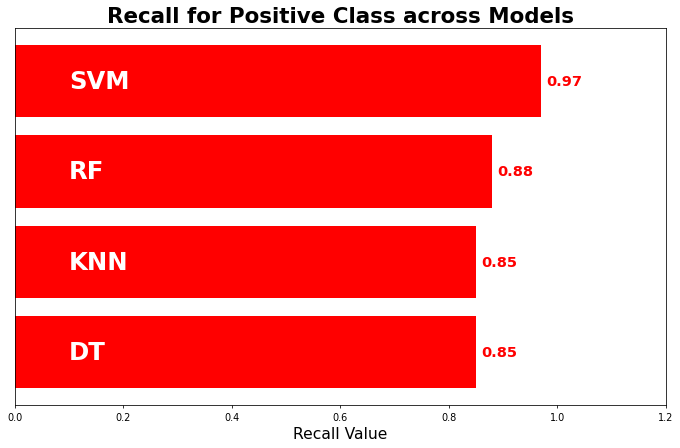

In [58]:
# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Recall Value', fontsize=16)
plt.show()

The SVM model demonstrates a commendable capability in recognizing potential heart patients. With a recall of 0.97 for class 1, it's evident that almost all patients with heart disease are correctly identified. This is of paramount importance in a medical setting. However, the model's balanced performance ensures that while aiming for high recall, it doesn't compromise on precision, thereby not overburdening the system with unnecessary alerts.